# Unsupervised learning

Zorg ervoor dat deze cellen vanboven naar beneden in het document uitgevoerd kunnen worden (Cell > Run All).
Verwijder ook de output voor het indienen om de bestandsgrootte te beperken (Cell > All Output > Clear). 

Vergeet ook niet te beantwoorden op de vragen over je oplossingen!

## Opgave 

De oefeningen in deze notebook focussen op de unsupervised learning technieken om clustering en dimensionality reduction uit te voeren.
Hiervoor wordt gebruik gemaakt van [deze dataset](https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv) die een reeks beelden van mensen met verschillend geslacht en ethniciteit bevat.
Voor elk beeld in deze dataset zijn drie labels toegevoegd, namelijk leeftijd, geslacht en ethniciteit.

Importeer alle benodigde packages hieronder en download deze dataset in de cell hieronder.
Merk op dat voor het inladen van de images zowel de os package en de cv2 package nodig zijn
Indien het cv2 package nog niet geinstalleerd is, kan het geinstalleerd worden met onderstaand commando:

In [ ]:
!pip install opencv-python

In [1]:
# alle imports hier
import os
import opendatasets as od
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# download
od.download("https://www.kaggle.com/nipunarora8/age-gender-and-ethnicity-face-data-csv")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jensbaetensodisee
Your Kaggle Key: ········


  0%|                                                                                      | 0.00/63.2M [00:00<?, ?B/s]

100%|█████████████████████████████████████████████████████████████████████████████| 63.2M/63.2M [00:02<00:00, 32.0MB/s]


Laad nu de dataset in in een dataframe en toon de kolommen die aanwezig zijn.

In [4]:
# inladen dataset
df = pd.read_csv("age-gender-and-ethnicity-face-data-csv/age_gender.csv")
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23705 entries, 0 to 23704
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        23705 non-null  int64 
 1   ethnicity  23705 non-null  int64 
 2   gender     23705 non-null  int64 
 3   img_name   23705 non-null  object
 4   pixels     23705 non-null  object
dtypes: int64(3), object(2)
memory usage: 926.1+ KB


,age,ethnicity,gender,img_name,pixels
0,1,2,0,20161219203650636.jpg.chip.jpg,129 128 128 126 127 130 133 135 139 142 145 14...
1,1,2,0,20161219222752047.jpg.chip.jpg,164 74 111 168 169 171 175 182 184 188 193 199...
2,1,2,0,20161219222832191.jpg.chip.jpg,67 70 71 70 69 67 70 79 90 103 116 132 145 155...
3,1,2,0,20161220144911423.jpg.chip.jpg,193 197 198 200 199 200 202 203 204 205 208 21...
4,1,2,0,20161220144914327.jpg.chip.jpg,202 205 209 210 209 209 210 211 212 214 218 21...


Merk op dat de kolom dat de pixels bevat het "object" datatype is. 
Dit komt omdat het een string bevat met een reeks getallen in. Schrijf hier nu een functie die de tekst van 1 figuur omzet naar een numpy matrix. 
De figuren in deze dataset zijn vierkantig dus de breedte en lengte is gelijk aan de vierkantswortel van het aantal pixels.
Ook is de figuur enkel grijswaarden dus kan je rechtstreeks de pixelwaarde gebruiken en heb je geen RGB waarde.
Daarnaast is het ook belangrijk voor het correct tekenen van de figuren om ervoor te zorgen dat het type van de numpy array integers bevat in plaats van strings.

In [10]:
# string to matrix function 
def string_to_matrix(text):
    # text naar een lijst met getallen als int
    lijst = [int(getal) for getal in text.split(" ")]
    # vierkantige figuur dus vierkantswortel, cast naar integer voor gehele waarde te hebben
    lengte = int(np.sqrt(len(lijst)))
    # lijst naar matrix
    return np.array(lijst).reshape((lengte, lengte))

string_to_matrix(df).shape

(48, 48)

Het is belangrijk op te merken dat de betekenis van de labels niet altijd eenduidig bepaald is. Toon daarom nu eerst een 5-tal willekeurige beelden met gender klasse 0 en 1. Wat is nu de betekenis van deze labels? Stelt label 0 een man of vrouw voor?

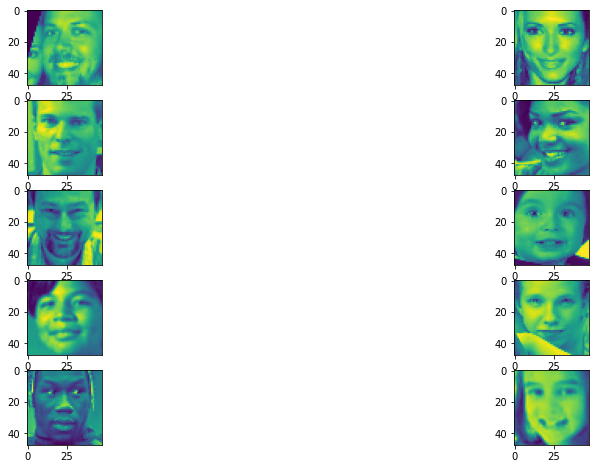

In [12]:
# show sample images for gender 0 en gender 1
num_figures = 5
labels = df.gender.unique()

# maak grafieken aan
fig, axs = plt.subplots(num_figures, len(labels), figsize=(16,8))

# iterate over labels (idx_lbl telt de index)
for idx_lbl, lbl in enumerate(labels):
    
    # bereken een sample van images van die klasse
    samples = df[df.gender == lbl].pixels.sample(num_figures)
    
    # toon de samples
    for idx_fig, figuur in enumerate(samples):
        axs[idx_fig, idx_lbl].imshow(string_to_matrix(figuur))

Doe dit ook voor de verschillende labels van etniciteit.
Welke ethniciteit komt overeen met welk label?
Indien het niet altijd snel duidelijk is, kan je het herhaaldelijk uitvoeren met andere figuren om een beter beeld te krijgen.

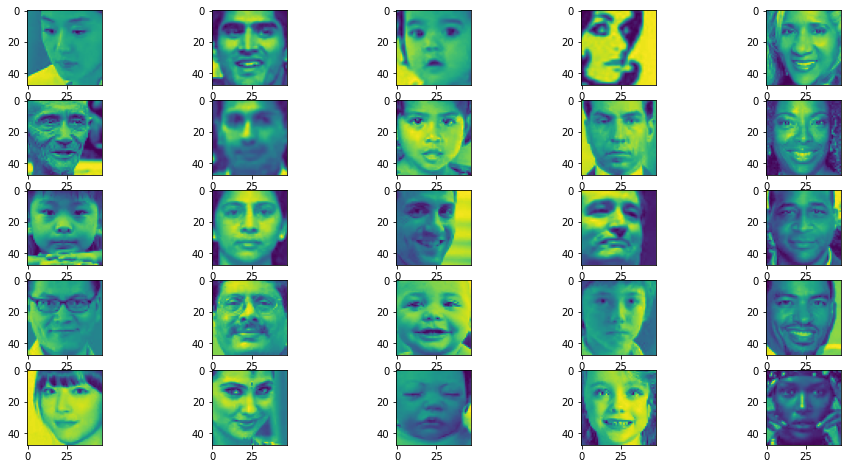

In [14]:
# show sample images for different ethnicities
num_figures = 5
labels = df.ethnicity.unique()

# maak grafieken aan
fig, axs = plt.subplots(num_figures, len(labels), figsize=(16,8))

# iterate over labels (idx_lbl telt de index)
for idx_lbl, lbl in enumerate(labels):
    
    # bereken een sample van images van die klasse
    samples = df[df.ethnicity == lbl].pixels.sample(num_figures)
    
    # toon de samples
    for idx_fig, figuur in enumerate(samples):
        axs[idx_fig, idx_lbl].imshow(string_to_matrix(figuur))

## Clustering

Voor we kunnen overgaan moet pixel kolom data nog omgezet worden bruikbare data.
Er zijn verscheidene mogelijkheden om dit te bereiken. Je kan bijvoorbeeld werken met de values van de pixel kolom.
Nadat deze dan gesplits worden kan je die omzetten naar een numpy matrix met een figuur per rij en de kolommen de verschillende pixelwaarden.

In [17]:
# convert pixel column to list of features
tmp = list(df.pixels.str.split().values)
X = np.matrix(tmp, dtype=int)

In [19]:
X.shape

(23705, 2304)

Nu dat de data ingeladen is, voer clustering uit door middel van K-Means clustering. 
Gebruik de Elbow methode om het optimale aantal clusters te bepalen.
Welk aantal clusters kies je? Kan je dit vergelijken met het aantal labels voor gender of ethniciteit?

In [20]:
# clustering for range of K-values
from sklearn.cluster import KMeans

Ks = [i+1 for i in range(10)]
scores = []

for k in Ks:
    kmeans = KMeans(n_clusters=k).fit(X)
    print("Num clusters: ", k, "met score", kmeans.score(X))
    scores.append(kmeans.score(X))    

Num clusters:  1 met score -167572801826.5942
Num clusters:  2 met score -136616345179.01547
Num clusters:  3 met score -125519252976.41129
Num clusters:  4 met score -117865124042.7209
Num clusters:  5 met score -111806540344.95738
Num clusters:  6 met score -108372269702.24089
Num clusters:  7 met score -105380868110.89268
Num clusters:  8 met score -103017164288.98358
Num clusters:  9 met score -100980688217.52231
Num clusters:  10 met score -99422357202.65501


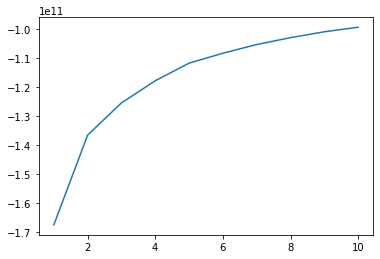

In [21]:
# show elbow plot for determining best value of K
plt.plot(Ks, scores)

**Antwoord:**

Train nu een clustering model met het K-Means algoritme voor K=5. 
Print een sample van 5 foto's in je subset voor elk van deze K's.
Indien je hierboven gewerkt hebt met numpy matrices, kan je gebruik maken van randint om willekeurige indices te selecteren.
Let ook op dat om de images goed te kunnen tonen, de vorm moet aangepast worden naar 48 bij 48 pixels.

In [22]:
# show sample images for different ethnicities
num_figures = 5
K=5

kmeans = KMeans(n_clusters =K).fit(X)
predicted_labels = kmeans.predict(X)

[1724   65 4005 2800 4608]
[2932 1254 3223 2236 3111]
[3843 2069 2843 3737 2306]
[3236 4429 1221 3473 2819]
[1686  552 2391 1587 1266]


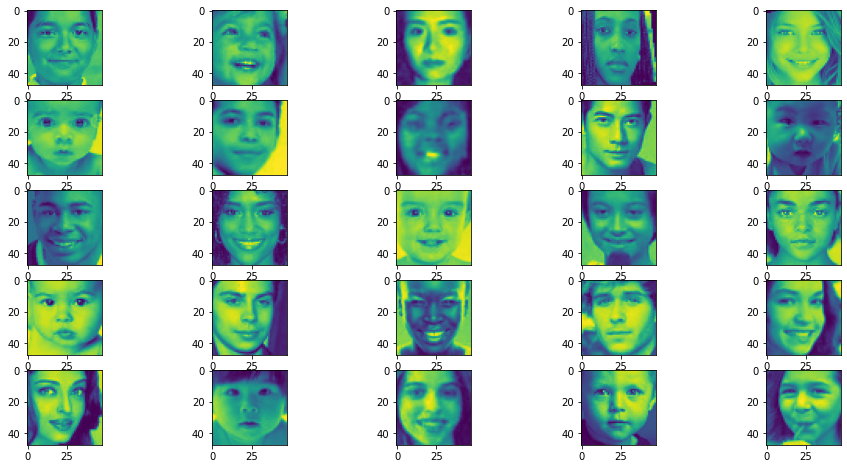

In [27]:
# maak grafieken aan
fig, axs = plt.subplots(num_figures, K, figsize=(16,8))

# iterate over alle clusters
for k in range(K):
    
    # bereken een sample van images van die klasse
    #samples = df[predicted_labels == k].pixels.sample(num_figures)
    samples = X[predicted_labels == k]
    
    idxs_to_show = np.random.randint(len(samples), size=num_figures)
    print(idxs_to_show)
        
    # toon de samples
    for idx_fig, idx_to_show in enumerate(idxs_to_show):
        axs[idx_fig, k].imshow(X[idx_to_show].reshape((48,48)))

**Kun je zien welke factoren gemeenschappelijk zijn in de clusters/waarop er vooral geclusterd wordt?
Het kan zijn dat dit niet eenvoudig te zien is maar doe een goede gok.**

**Antwoord:**

## PCA

De figuren in de dataset die gebruikt is voor clustering waren 48 pixels bij 48 en waren in grijswaarden maar toch leverde dit reeds 2304 features op.
Het is dus duidelijk dat bij computer visie het aantal features heel snel kan oplopen.
In deze sectie gaan we op zoek naar andere manieren om de beschikbare data voor te stellen om het aantal features te kunnen reduceren maar toch zo veel mogelijke informatie te behouden.
Om dit te bereiken gaan we gebruik maken van de Principal Component Analyse of PCA.

De eerste stap is om te bekijken hoeveel components er nodig zijn om nog een redelijk deel van de beschikbare informatie over te houden.
Toon dit aan de hand van een plot dat de variantie toont in functie van de principal components.

Text(0, 0.5, 'cumulative explained variance')

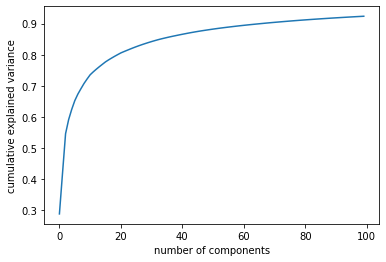

In [29]:
from sklearn.decomposition import PCA

pca = PCA(100).fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")

Hoeveel components zijn er nodig om ongeveer 80% en 90% van de informatie over te houden?

**Antwoord:** 20-60

Teken nu de volgende twee figuren naast elkaar:
* Een willekeurige figuur uit de dataset
* Het resultaat na PCA met voldoende componenten om minstens 90% van de variantie te behouden. (Je kan hier niet rechtstreeks het resultaat van de transform functie() voor gebruiken omdat dit een rij is ipv een matrix).

In [37]:
def plot_pca(fig1, fig2):
    
    fig,axes = plt.subplots(1,2, figsize=(16,8))
    axes[0].imshow(fig1.reshape(48,48))
    axes[1].imshow(fig2.reshape(48,48))

In [39]:
pca = PCA(0.9)
X2 = pca.fit_transform(X)
X_after = pca.inverse_transform(X2)

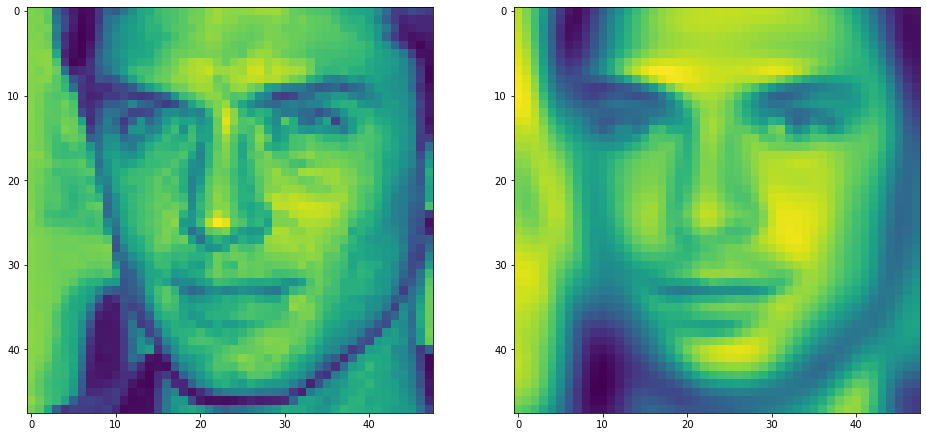

In [40]:
idx = np.random.randint(len(X))

plot_pca(X[idx], X_after[idx])

In deze resultaten zou het origineel nog steeds zichtbaar moeten zijn maar het zou wel waziger moeten zijn.
Indien er gewenst is om 90% van de variantie te behouden, met hoeveel percent kan de dataset dan gereduceerd worden?

**Antwoord:**

In [43]:
num_features = 2304
num_features_left = pca.n_components_

num_features_left/num_features*100

2.907986111111111